In [1]:
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
scope = ["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',"https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]

In [3]:
creds = ServiceAccountCredentials.from_json_keyfile_name("creds.json", scope)
client = gspread.authorize(creds)

In [4]:
#spreadsheets with different dates placed in separate worksheets
spreadsheet_old = client.open_by_url("https://docs.google.com/spreadsheets/d/1yZv9w9zRKwrGTaR-YzmAqMefw4wMlaXocejdxZaTs6w/edit#gid=638231677")
spreadsheet = client.open_by_url("https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/htmlview?usp=sharing&sle=true")
#spreadsheet with 3 worksheets - Confirmed, Deaths, Recovered - columns are dates
spreadsheet_time_series = client.open_by_url("https://docs.google.com/spreadsheets/d/1UF2pSkFTURko2OvfHWWlFpDFAr1UxCBA4JLwlSP6KFo/htmlview?usp=sharing&sle=true")

In [5]:
### lists and dicts to help clear dataframes
#list of columns i want to keep
const_cols = ["Province/State", "Country", "Country/Region", "Date last updated", "Last Update", "Confirmed", "Recovered", "Deaths"]
#dict of column names to change
column_names = {"Country": "Country/Region", "Date last updated": "Last Update"}
#dict of columns and values to put in NaNs
fillna_values = {'Province/State': "", "Country/Region": "", "Confirmed": 0, "Recovered": 0, "Deaths":0}

In [6]:
#lists with worksheets
list_dates = spreadsheet.worksheets()
list_time_series = spreadsheet_time_series.worksheets()

In [7]:
#list to help change column names
list_of_column_names = []

def read_spreadsheets(spreadsheet, list_dates,save):
    titles = []
    df_list = []

    for df in list_dates:
        #get worksheet as df
        title = df.title
        titles.append(title)
        df = get_as_dataframe(spreadsheet.worksheet(title))
        # delete columns i don't need
        for col in df.columns:
            if not col in const_cols:
                df = df.drop(labels=col, axis=1)
        #get column names that stayed in list of dfs
#         for col in df.columns:
#             if not col in list_of_column_names:
#                 list_of_column_names.append(col)

        #drop columns and rows with only NaNs
        df = df.dropna(axis=0, how='all')
        df = df.dropna(axis=1, how='all')

        # changing column names to standarise it
        df = df.rename(columns=column_names)

        #filling NaNs
        df = df.fillna(value=fillna_values)

        #adding dfs to df_list
        df_list.append(df)

    #save multiple sheets to excel
    if save == True:
        writer = pd.ExcelWriter('2019_nCoV_multiple_sheets.xlsx', engine='xlsxwriter')

        for i, df in enumerate(df_list, 0):
            df.to_excel(writer, sheet_name=titles[i], index=False)

        writer.save()

    return df_list

In [8]:
def big_df(df_list,fillna_values):
    #make df is a first date df for a start
    main_df = df_list[len(df_list) - 1]
    #adding next dfs to main_df
    for i in range(0, len(df_list) - 1):
        main_df = pd.concat([main_df, df_list[len(df_list) - 1 - i]], axis=0, ignore_index=True, sort=False)
    main_df = main_df.fillna(value=fillna_values)
    return main_df

In [9]:
def read_time_series_spreadsheets(spreadsheet_time_series,list,save):
    titles = []
    df_list = []

    for df in list:
        # get worksheet as df
        title = df.title
        titles.append(title)
        df = get_as_dataframe(spreadsheet_time_series.worksheet(title))

        df = df.dropna(axis=0, how='all')
        df = df.dropna(axis=1, how='all')

        df_text = df[df.columns[0:2]]
        df_text = df_text.fillna(value = '')
        df_val = df[df.columns[2:len(df.columns)]]
        df_val = df_val.fillna(value = 0)
        df = pd.concat([df_text,df_val],axis=1)
        df_list.append(df)

    if save == True:
        writer = pd.ExcelWriter('2019_nCoV_time_series.xlsx', engine='xlsxwriter')

        for i, df in enumerate(df_list,0):
            df.to_excel(writer,sheet_name=titles[i], index=False)

        writer.save()

    return df_list

In [10]:
df_list = read_spreadsheets(spreadsheet,list_dates,save=True)

In [11]:
ts_df_list = read_time_series_spreadsheets(spreadsheet_time_series, list_time_series, save=True)

In [12]:
main_df = big_df(df_list,fillna_values)

In [13]:
main_df.to_excel('2019_nCoV.xlsx', sheet_name="2019_nCoV_all_data",index=False)

In [14]:
print("Shape of dataframe: {}".format(ts_df_list[0].shape))
#printing whole df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(ts_df_list[0])

Shape of dataframe: (72, 40)


In [15]:
#confirmed time series df
#time_series_df_list[0]

In [16]:
#
china_confirmed_series = ts_df_list[0][ts_df_list[0]['Country/Region']=="Mainland China"].iloc[:,5:].sum(axis=0)
china_recovered_series = ts_df_list[1][ts_df_list[1]['Country/Region']=="Mainland China"].iloc[:,5:].sum(axis=0)
china_deaths_series = ts_df_list[2][ts_df_list[2]['Country/Region']=="Mainland China"].iloc[:,5:].sum(axis=0)
#print(china_confirmed_series)
#print(china_recovered_series)
#print(china_deaths_series)

In [59]:
dates_0 = china_confirmed_series.index.values
dates_1 = china_recovered_series.index.values
dates_2 = china_deaths_series.index.values

print(dates_0)
#print(dates_1)
#print(dates_2)

dates_datetime_0 = pd.to_datetime(dates_0, infer_datetime_format=True)
dates_datetime_1 = pd.to_datetime(dates_1, infer_datetime_format=True)
dates_datetime_2 = pd.to_datetime(dates_2, infer_datetime_format=True)

print(dates_datetime_0)


['1/22/2020 12:00 PM' '1/23/2020 12:00 PM' '1/24/2020 12:00 AM'
 '1/24/2020 12:00 PM' '1/25/2020 12:00 AM' '1/25/2020 12:00 PM'
 '1/25/2020 10:00 PM' '1/26/2020 11:00 AM' '1/26/2020 11:00 PM'
 '1/27/2020 9:00 AM' '1/27/2020 7:00 PM' '1/27/2020 8:30 PM'
 '1/28/2020 1:00 PM' '1/28/2020 6:00 PM' '1/28/2020 11:00 PM'
 '1/29/2020 1:30 PM' '1/29/2020 2:30 PM' '1/29/2020 9:00 PM'
 '1/30/2020 11:00 AM' '1/31/2020 2:00 PM' '2/1/2020 10:00 AM'
 '2/2/2020 9:00 PM' '2/3/2020 9:00 PM' '2/4/2020 9:40 AM'
 '2/4/2020 10:00 PM' '2/5/2020 9:00 AM' '2/5/2020 11:00 PM'
 '2/6/2020 9:00 AM' '2/6/2020 2:20 PM' '2/7/2020 8:13 PM'
 '2/7/2020 10:50 PM' '2/8/2020 10:04 PM' '2/8/20 23:04'
 '02/09/2020 10:30 AM' '2/9/20 23:20']
DatetimeIndex(['2020-01-22 12:00:00', '2020-01-23 12:00:00',
               '2020-01-24 00:00:00', '2020-01-24 12:00:00',
               '2020-01-25 00:00:00', '2020-01-25 12:00:00',
               '2020-01-25 22:00:00', '2020-01-26 11:00:00',
               '2020-01-26 23:00:00', '2020-01-

In [57]:
#something for converting datetime for x axis
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

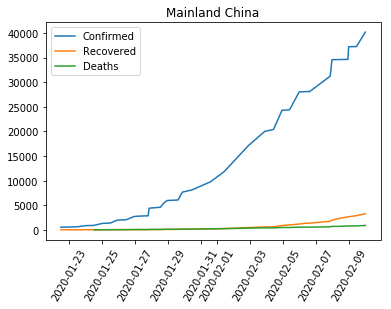

In [58]:
plt.plot(dates_datetime_0, china_confirmed_series, dates_datetime_1, china_recovered_series, dates_datetime_2, china_deaths_series)
plt.xticks(rotation=60)
plt.legend(['Confirmed', 'Recovered', 'Deaths'])
plt.title("Mainland China")
plt.savefig("img/china.png",bbox_inches='tight')

In [60]:
countries_ts = ts_df_list[0]['Country/Region'].unique()
print(len(countries_ts))
print(countries_ts)

29
['Mainland China' 'Thailand' 'Japan' 'South Korea' 'Taiwan' 'US' 'Macau'
 'Hong Kong' 'Singapore' 'Vietnam' 'France' 'Nepal' 'Malaysia' 'Canada'
 'Australia' 'Cambodia' 'Sri Lanka' 'Germany' 'Finland'
 'United Arab Emirates' 'Philippines' 'India' 'Italy' 'UK' 'Russia'
 'Sweden' 'Spain' 'Belgium' 'Others']


In [61]:
#for country in countries_ts:
    #plt.plot(dates_datetime, ts_df_list[0][ts_df_list[0]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    #plt.show()

In [62]:
import math

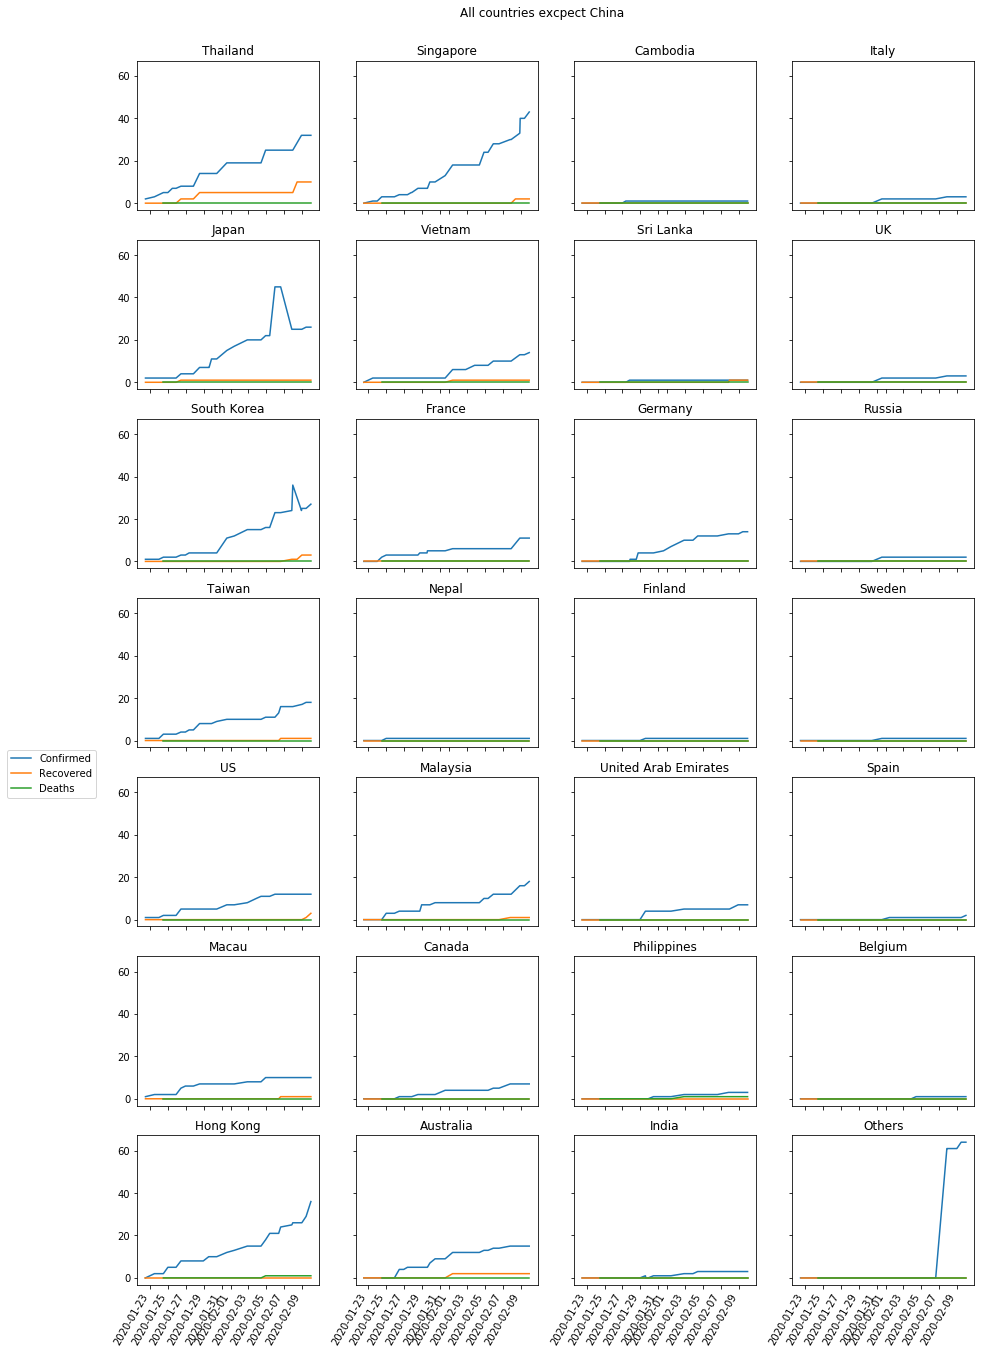

In [64]:
country_confirmed_series = ts_df_list[0][ts_df_list[0]['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
country_recovered_series = ts_df_list[1][ts_df_list[1]['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
country_deaths_series = ts_df_list[2][ts_df_list[2]['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
dates_0 = country_confirmed_series.index.values
dates_datetime_0 = pd.to_datetime(dates_0, infer_datetime_format=True)
dates_1 = country_recovered_series.index.values
dates_datetime_1 = pd.to_datetime(dates_1, infer_datetime_format=True)
dates_2 = country_deaths_series.index.values
dates_datetime_2 = pd.to_datetime(dates_2, infer_datetime_format=True)
    
plots_in_row = 4
#define how many rows on how many countries in list without china
plots_in_col = math.floor((len(countries_ts)-1)/4)

fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, 25), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_ts[1:]:
    
    axs[i][j].plot(dates_datetime_0,ts_df_list[0][ts_df_list[0]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    axs[i][j].plot(dates_datetime_1,ts_df_list[1][ts_df_list[1]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    axs[i][j].plot(dates_datetime_2,ts_df_list[2][ts_df_list[2]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('All countries excpect China',y=0.91)
fig.legend(['Confirmed', 'Recovered', 'Deaths'],loc='upper left', bbox_to_anchor=(0., 0., 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
plt.savefig("img/rest.png",bbox_inches='tight')